# Installing dependencies and required libraries

In [2]:
!pip install datasets transformers
!pip install py7zr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.3 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4

In [3]:
from datasets import load_dataset
from pprint import pprint
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import Counter
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from tqdm import tqdm

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


# Loading the dataset

The dataset is loaded from the HuggingFace hub as a Python dictionary using the `load_dataset` function. The "Samsung/samsum" dataset is designed for training and evaluating dialogue summarization models. It contains realistic dialogues written by linguists fluent in English and provides a high-quality resource for summarization tasks.

In [4]:
dataset = load_dataset("samsum",trust_remote_code=True)

print(dataset)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
})


In [5]:
print(type(dataset))
print(type(dataset['train']))
print(type(dataset['train'][0]))

<class 'datasets.dataset_dict.DatasetDict'>
<class 'datasets.arrow_dataset.Dataset'>
<class 'dict'>


The output shows that the dataset is structured as a `DatasetDict`, containing `Dataset` objects for each subset. Each example in the dataset is a dictionary. It is divided into train, validation and test set. Each sample record contains a dialogue that have to be summarized, an id and summary representing the golden summary.


In [6]:
example = dataset['test'][5]

pprint(example)

{'dialogue': 'Benjamin: Hey guys, what are we doing with the keys today?\r\n'
             "Hilary: I've got them. Whoever wants them can meet me at "
             'lunchtime or after\r\n'
             "Elliot: I'm ok. We're meeting for the drinks in the evening "
             "anyway and I guess we'll be going back to the apartment "
             'together?\r\n'
             'Hilary: Yeah, I guess so\r\n'
             "Daniel: I'm with Hilary atm and won't let go of her for the rest "
             'of the day, so any option you guys choose is good for me\r\n'
             'Benjamin: Hmm I might actually pass by at lunchtime, take the '
             "keys and go take a nap. I'm sooo tired after yesterday\r\n"
             "Hilary: Sounds good. We'll be having lunch with some French "
             'people (the ones who work on the history of food in colonial '
             'Mexico - I already see you yawning your head off)\r\n'
             'Benjamin: YAAAAWN 🙊 Where and where are you m

Exploring the chats we can find emojis and <file_gif\> along with slang terms.

# Data analysis

In order to have a faster access to the data we've decided to convert the dictionaries into DataFrames.

In [7]:
data_list_train = []
for dialogue_id, (dialogue_text, summary_text) in enumerate(zip(dataset['train']['dialogue'], dataset['train']['summary'])):
    data_list_train.append({
        'dialogue_id': dialogue_id,
        'dialogue_text': dialogue_text,
        'summary': summary_text
    })

# Create DataFrame
df = pd.DataFrame(data_list_train)

data_list_val = []
for dialogue_id, (dialogue_text, summary_text) in enumerate(zip(dataset['validation']['dialogue'], dataset['validation']['summary'])):
    data_list_train.append({
        'dialogue_id': dialogue_id,
        'dialogue_text': dialogue_text,
        'summary': summary_text
    })

df_val = pd.DataFrame(data_list_val)

data_list_test = []
for dialogue_id, (dialogue_text, summary_text) in enumerate(zip(dataset['test']['dialogue'], dataset['test']['summary'])):
    data_list_train.append({
        'dialogue_id': dialogue_id,
        'dialogue_text': dialogue_text,
        'summary': summary_text
    })

df_test = pd.DataFrame(data_list_test)

### Check for missing values

In [8]:
missing_dialogues_index = []
for index , row in df.iterrows():
  if(row['dialogue_text'] == ''):
    missing_dialogues_index.append(index)

print("There are missing", len(missing_dialogues_index), "dialogues in the training set!")

There are missing 1 dialogues in the training set!


In [9]:
for index in missing_dialogues_index:
  print(dataset['train'][index])

{'id': '13828807', 'dialogue': '', 'summary': 'problem with visualization of the content'}


In [10]:
for i in missing_dialogues_index:
  df = df.drop(i)

print(len(df))

14731


In [11]:
missing_dialogues_index = []
for index , row in df_val.iterrows():
  if(row['dialogue_text'] == ''):
    missing_dialogues_index.append(index)

print("There are missing", len(missing_dialogues_index), "dialogues in the validation set!")

There are missing 0 dialogues in the validation set!


In [12]:
missing_dialogues_index = []
for index , row in df_test.iterrows():
  if(row['dialogue_text'] == ''):
    missing_dialogues_index.append(index)

print("There are missing", len(missing_dialogues_index), "dialogues in the test set!")

There are missing 0 dialogues in the test set!


### Analysis to see the average length of chats

In [13]:
def count_msgs(dialogue):
  new_line = "\n"
  msgs = dialogue.count(new_line) + 1 # One message is added since the last message has no \n
  return msgs

df['count_msgs'] = df['dialogue_text'].apply(count_msgs)

print("On average there are {:.2f} messages per chat".format(df['count_msgs'].mean()))

On average there are 11.17 messages per chat


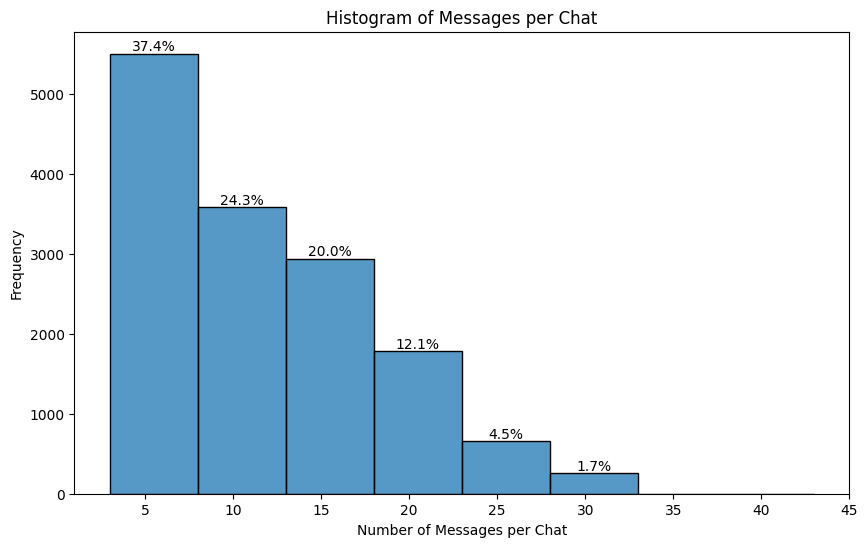

In [14]:
min_msgs = df['count_msgs'].min()
max_msgs = df['count_msgs'].max()
bins = range(min_msgs, max_msgs + 1, 5)

plt.figure(figsize=(10, 6))
sns.histplot(df['count_msgs'], bins=bins, kde=False)

total = len(df['count_msgs'])

for p in plt.gca().patches:
    height = p.get_height()
    if(height / total * 100)>0:
      plt.gca().annotate('{:.1f}%'.format(height / total * 100),
                        (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='bottom')

plt.xlabel('Number of Messages per Chat')
plt.ylabel('Frequency')
plt.title('Histogram of Messages per Chat')

plt.show()

We notice how the majority of the chats have 5-10 messages. However longer chats are not missing.

### Analysis to see how many people per chat

In [15]:
def people_per_chat(dialogue):
  matches = re.findall(r'\b(.+):', dialogue)
  return len(set(matches))

df['people_chat'] = df['dialogue_text'].apply(people_per_chat)

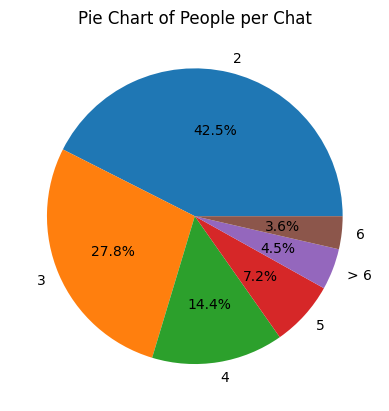

In [16]:
df['people_chat_classified'] = df['people_chat'].apply(lambda x: '> 6' if x > 6 else x)
value_counts = df['people_chat_classified'].value_counts()
value_counts.plot(kind='pie', autopct='%1.1f%%')
plt.ylabel('')
plt.title('Pie Chart of People per Chat')
plt.show()

Majority of the chats are between two people. However the cumulative percentage of chats containing more than 2 people is 57,5% being a suitable dataset for our task.

### Analysis to see the average length of golden summaries

In [20]:
df['summary_word_length'] = df['summary'].apply(lambda x: len(x.split()))

average_word_length = df['summary_word_length'].mean()

print(f"The average length of summaries in terms of words is: {average_word_length}")

The average length of summaries in terms of words is: 20.318444097481503


### Vocabulary size of the dialogues

In [18]:
df['dialogue_tokens'] = df['dialogue_text'].apply(lambda x: word_tokenize(x.lower()))
df['summary_tokens'] = df['summary'].apply(lambda x: word_tokenize(x.lower()))

dialogue_words = [word for tokens in df['dialogue_tokens'] for word in tokens]
summary_words = [word for tokens in df['summary_tokens'] for word in tokens]

dialogue_vocab_size = len(Counter(dialogue_words))
summary_vocab_size = len(Counter(summary_words))

print(f"Dialogue Vocabulary Size: {dialogue_vocab_size}")
print(f"Summary Vocabulary Size: {summary_vocab_size}")

Dialogue Vocabulary Size: 32821
Summary Vocabulary Size: 16825


Summaries have a smaller vocabulary size reflecting their role in efficient communication. They distill complex dialogue content into a streamlined form that is easier to understand and digest, making them suitable for quick reference or overview.